In [1]:
%matplotlib inline
import sys
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.detection as afw_detect
import lsst.afw.image as afw_image
import lsst.afw.geom as afw_geom
import lsst.afw.math as afw_math

In [2]:
def get_bbox(keyword, dxmin=0, dymin=0, dxmax=0, dymax=0):
    """
    Parse an NOAO section keyword value (e.g., DATASEC =
    '[1:509,1:200]') from the FITS header and return the corresponding
    bounding box for sub-image retrieval.
    """
    xmin, xmax, ymin, ymax \
        = [val - 1 for val in eval(keyword.replace(':', ','))]
    bbox = afw_geom.Box2I(afw_geom.Point2I(xmin + dxmin, ymin + dymin),
                          afw_geom.Point2I(xmax + dxmax, ymax + dymax))
    return bbox

def trimmed_image(decam_file, hdu, trimsec, biassec):
    """
    Read in an HDU from the DECam file, do an overscan subtraction
    and return the trimmed image.
    """
    full_image = afw_image.ImageF(decam_file, hdu)
    md = afw_image.readMetadata(decam_file, hdu)
    image = full_image[get_bbox(md.getScalar(trimsec))]
    oscan = full_image[get_bbox(md.getScalar(biassec))]
    oscan_rows = np.array([np.median(oscan.array[j,])
                           for j in range(oscan.array.shape[0])])
    ny, nx = image.array.shape
    for j in range(ny):
        image.array[j,] -= oscan_rows[j]
    return image

def get_footprint_set(image, npix_min=2, nsig=20):
    """
    Set threshold at nsig*stdevclip + median and return
    footprint set of detected objects.
    """
    stats = afw_math.makeStatistics(image, afw_math.MEDIAN | afw_math.STDEVCLIP)
    median = stats.getValue(afw_math.MEDIAN)
    stdev_clip = stats.getValue(afw_math.STDEVCLIP)
    threshold_value = median + nsig*stdev_clip
    threshold = afw_detect.Threshold(threshold_value)
    return afw_detect.FootprintSet(image, threshold, npix_min)

def exptime(decam_file):
    "Read the exposure time from the EXPTIME header keyword."
    md = afw_image.readMetadata(decam_file)
    return md.getScalar('EXPTIME')

In [3]:
# DECam darks at http://data.darkenergysurvey.org/fnalmisc/decamdarks/
decam_file = 'DECam_00500238.fits.fz'
CR_count = defaultdict(lambda: 0)
for hdu in range(1, 63):
    sys.stdout.write('%i ' % hdu)
    for amp in 'AB':
        trimsec = 'TRIMSEC' + amp
        biassec = 'BIASSEC' + amp
        image = trimmed_image(decam_file, hdu, trimsec, biassec)
        fp_set = get_footprint_set(image)
        CR_count[hdu] += len(fp_set.getFootprints())

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 

Median # CRs per CCD: 682.0


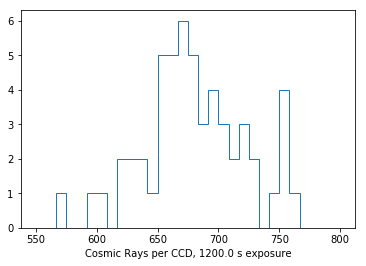

In [4]:
exptime = exptime(decam_file)
values = list(CR_count.values())
plt.hist(values, bins=30, histtype='step', range=(550, 800))
plt.xlabel('Cosmic Rays per CCD, {} s exposure'.format(exptime))
median_count = np.median(values)
print("Median # CRs per CCD:", median_count)

In [5]:
# DECam CCD physical parameters
pixel_size = 15 # microns
thickness = 250 # microns
num_pixels = 4096*2048

CR_rate = median_count/pixel_size**2/thickness/num_pixels/exptime
print("Cosmic-ray rate at CTIO: {:.2e} CR/s/micron**3\n".format(CR_rate))

pixel_lsst = 10 # micron
thickness_lsst = 100 # micron
num_pixels_lsst = 4072*4000
exptime_lsst = 30 # s

LSST_CRs = CR_rate*pixel_lsst**2*thickness_lsst*num_pixels_lsst*exptime_lsst
print('Cosmic-rays per CCD per 30s exposure at LSST: {:.2f}'.format(LSST_CRs))

Cosmic-ray rate at CTIO: 1.20e-12 CR/s/micron**3

Cosmic-rays per CCD per 30s exposure at LSST: 5.89
